In [1]:
import numpy as np
import math
import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

In [2]:
batch_size = 128
epochs = 50
temperature = 1.0

In [3]:
# MNIST Data
train_loader = torch.utils.data.DataLoader(
datasets.MNIST('./data/MNIST', train=True, download=True,
transform=transforms.ToTensor()),
batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
datasets.MNIST('./data/MNIST', train=False, transform=transforms.ToTensor()),
batch_size=batch_size, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



In [4]:
import argparse
parser = argparse.ArgumentParser()
parser.add_argument('--input_dim', type=int,default = 28)
parser.add_argument('--hidden_dim', type=int,default = 256)
parser.add_argument('--categorical_dim', type=int,default = 10)
parser.add_argument('--n_samples', type=int,default = 32)
parser.add_argument('--temp', type=float,default = 1.)

_StoreAction(option_strings=['--temp'], dest='temp', nargs=None, const=None, default=1.0, type=<class 'float'>, choices=None, help=None, metavar=None)

In [5]:
# gumbel softmax by myself
class GumbelVAE(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.args = args
        self.encoder = nn.Sequential(nn.Linear(self.args.input_dim**2, self.args.hidden_dim), nn.ReLU(),\
                                     nn.Linear(self.args.hidden_dim,self.args.n_samples*self.args.categorical_dim))
        self. decoder = nn.Sequential(nn.Linear(self.args.n_samples*self.args.categorical_dim, self.args.hidden_dim), nn.ReLU(),\
                                     nn.Linear(self.args.hidden_dim,self.args.input_dim**2),nn.Sigmoid())
    def sample(self, logits):
        # logits - bs, n_samples * categorical_dim
        logits = logits.reshape(-1,self.args.n_samples, self.args.categorical_dim) # bs, n_samples, categorical_dim
        # logits - log(π_i)
        gi = self.gumbel_sample(logits)
        yi = F.softmax((logits+gi)/self.args.temp, dim=-1)
        return yi

    def gumbel_sample(self, logits, eps = 1e-20):
        ui = torch.rand(logits.shape, device = logits.device) 
        gi = -torch.log(-torch.log(ui+eps)+eps)
        return gi
    
    def forward(self, input):
        # input - bs, input_dim
        input = input.reshape(-1, self.args.input_dim**2)
        encoder_output = self.encoder(input) # bs, n_sample*categorical_dim
        q_z = F.softmax(encoder_output.reshape(-1,self.args.n_samples, self.args.categorical_dim), dim=-1)
        gumbel_sample = self.sample(encoder_output) # bs, n_sample, categorical_dim
        decoder_input = gumbel_sample.reshape(-1, self.args.n_samples*self.args.categorical_dim)
        decoder_output = self.decoder(decoder_input)  # bs, input_dim**2
        return decoder_output, q_z

In [6]:
args,_ = parser.parse_known_args()

In [24]:
model = GumbelVAE(args)
model = model.cuda()

In [25]:
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

In [11]:
from matplotlib import pyplot as plt

In [12]:
def loss_fct(output, input, dim, categorical_dim):
    output, q_z = output
    input = input.reshape(-1, dim**2)
    bce = F.binary_cross_entropy(output,input,size_average=False)/input.size(0)
    # qz # bs, n_samples, categorical_dim
    kld = torch.sum(torch.log(q_z*categorical_dim)*q_z,dim=-1).mean()# bs, n_sample,categorical_dim
    return bce, kld

In [23]:
def eval(model, test_dataloader):
    model.eval()
    val_bce_loss = 0.
    val_kld = 0.
    count = {}
    with torch.no_grad():
        for data in tqdm(test_dataloader):
            data,label = data[0].cuda(),data[1]
            output = model(data)
            bce,kld = loss_fct(output, data, args.input_dim, args.categorical_dim)
            loss = bce+kld
            #loss.backward()
            val_bce_loss+=bce.item()
            val_kld+=kld.item()
            #optimizer.step()
    plt.imshow(data[0,0,:,:].cpu().numpy())
    plt.show()
    plt.imshow(output[0].cpu().detach().numpy().reshape(-1,args.input_dim, args.input_dim)[0])
    plt.show()
    return val_bce_loss, val_kld

  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
100%|██████████| 469/469 [00:05<00:00, 91.45it/s]


epoch 1 train bce loss 81335.7586 train kld 905.7982


100%|██████████| 79/79 [00:00<00:00, 109.31it/s]


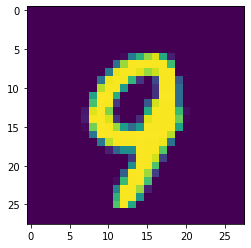

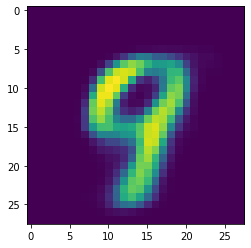

epoch 1 test bce loss 10386.3483 test kld 160.3817


100%|██████████| 469/469 [00:05<00:00, 84.54it/s]


epoch 2 train bce loss 56043.7462 train kld 926.2559


100%|██████████| 79/79 [00:00<00:00, 97.96it/s] 


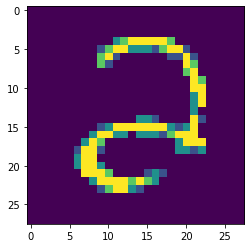

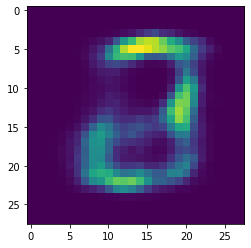

epoch 2 test bce loss 8423.9119 test kld 154.2270


100%|██████████| 469/469 [00:05<00:00, 90.44it/s]


epoch 3 train bce loss 47700.5277 train kld 918.0338


100%|██████████| 79/79 [00:00<00:00, 109.08it/s]


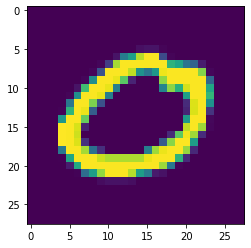

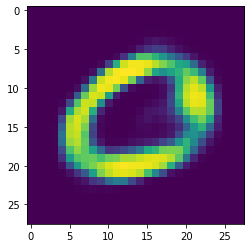

epoch 3 test bce loss 7567.8213 test kld 155.4155


100%|██████████| 469/469 [00:05<00:00, 91.72it/s]


epoch 4 train bce loss 44076.0005 train kld 921.3620


100%|██████████| 79/79 [00:00<00:00, 110.15it/s]


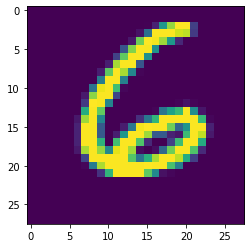

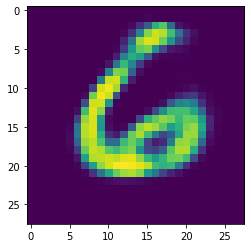

epoch 4 test bce loss 7149.6149 test kld 154.8421


100%|██████████| 469/469 [00:05<00:00, 91.57it/s]


epoch 5 train bce loss 41929.5878 train kld 916.5673


100%|██████████| 79/79 [00:00<00:00, 109.67it/s]


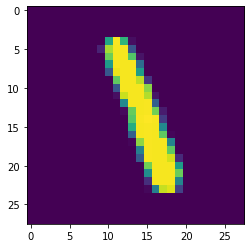

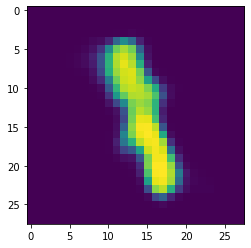

epoch 5 test bce loss 6836.5033 test kld 154.5411


100%|██████████| 469/469 [00:05<00:00, 91.26it/s]


epoch 6 train bce loss 40382.5945 train kld 913.6271


100%|██████████| 79/79 [00:00<00:00, 107.90it/s]


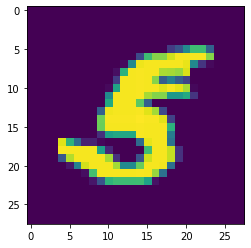

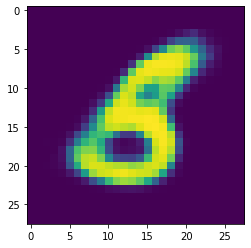

epoch 6 test bce loss 6639.1348 test kld 153.8125


100%|██████████| 469/469 [00:05<00:00, 91.21it/s]


epoch 7 train bce loss 39264.6766 train kld 909.3663


100%|██████████| 79/79 [00:00<00:00, 108.22it/s]


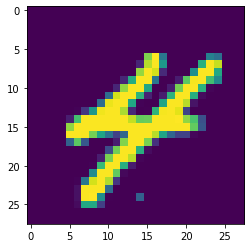

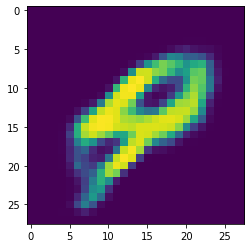

epoch 7 test bce loss 6488.4913 test kld 152.8134


100%|██████████| 469/469 [00:05<00:00, 90.46it/s]


epoch 8 train bce loss 38403.6115 train kld 908.2064


100%|██████████| 79/79 [00:00<00:00, 109.19it/s]


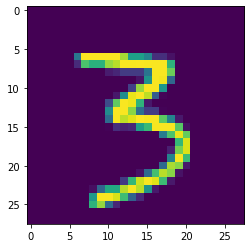

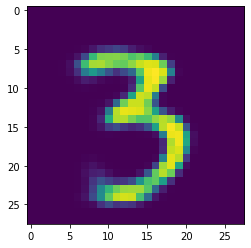

epoch 8 test bce loss 6356.4121 test kld 152.6857


100%|██████████| 469/469 [00:05<00:00, 91.19it/s]


epoch 9 train bce loss 37736.9762 train kld 904.9078


100%|██████████| 79/79 [00:00<00:00, 109.01it/s]


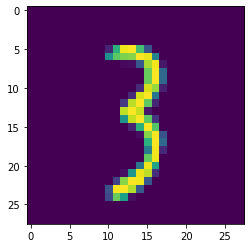

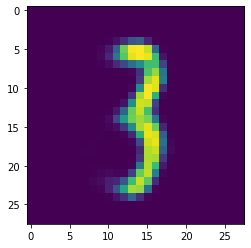

epoch 9 test bce loss 6267.8278 test kld 152.3229


100%|██████████| 469/469 [00:05<00:00, 90.11it/s]


epoch 10 train bce loss 37157.8770 train kld 902.7408


100%|██████████| 79/79 [00:00<00:00, 107.39it/s]


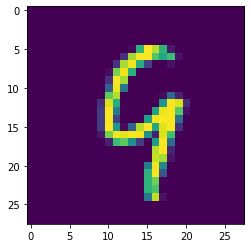

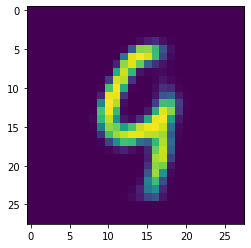

epoch 10 test bce loss 6190.7608 test kld 152.1287


100%|██████████| 469/469 [00:05<00:00, 91.31it/s]


epoch 11 train bce loss 36654.7722 train kld 900.6185


100%|██████████| 79/79 [00:00<00:00, 107.55it/s]


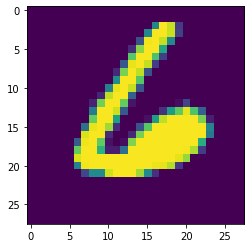

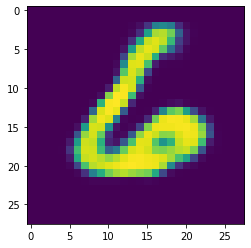

epoch 11 test bce loss 6101.3599 test kld 151.6726


100%|██████████| 469/469 [00:05<00:00, 90.28it/s]


epoch 12 train bce loss 36267.8690 train kld 900.6619


100%|██████████| 79/79 [00:00<00:00, 106.60it/s]


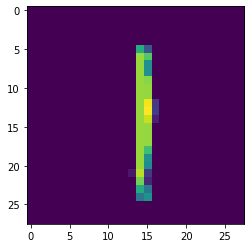

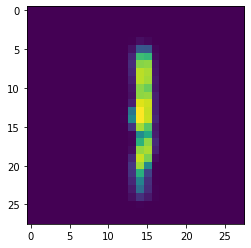

epoch 12 test bce loss 6052.0282 test kld 151.7691


100%|██████████| 469/469 [00:05<00:00, 90.18it/s]


epoch 13 train bce loss 35907.0223 train kld 899.3739


100%|██████████| 79/79 [00:00<00:00, 109.31it/s]


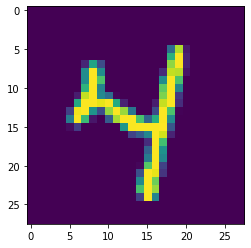

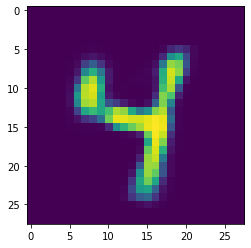

epoch 13 test bce loss 5993.4114 test kld 151.0479


100%|██████████| 469/469 [00:05<00:00, 91.19it/s]


epoch 14 train bce loss 35570.4634 train kld 895.9463


100%|██████████| 79/79 [00:00<00:00, 107.53it/s]


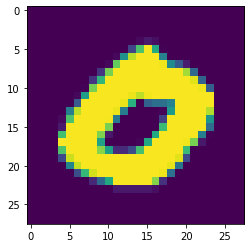

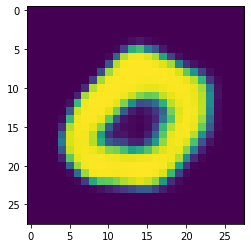

epoch 14 test bce loss 5955.7157 test kld 150.3805


100%|██████████| 469/469 [00:05<00:00, 90.67it/s]


epoch 15 train bce loss 35252.4158 train kld 890.7608


100%|██████████| 79/79 [00:00<00:00, 107.12it/s]


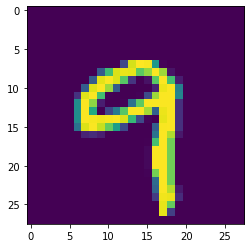

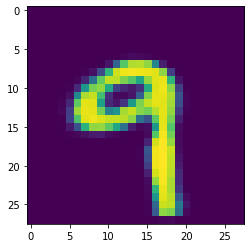

epoch 15 test bce loss 5910.7357 test kld 149.5789


100%|██████████| 469/469 [00:05<00:00, 90.06it/s]


epoch 16 train bce loss 34973.3305 train kld 889.0577


100%|██████████| 79/79 [00:00<00:00, 106.89it/s]


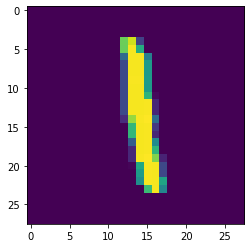

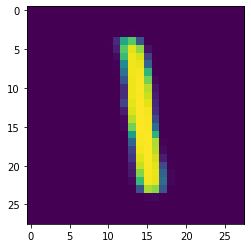

epoch 16 test bce loss 5849.6510 test kld 149.8199


100%|██████████| 469/469 [00:05<00:00, 90.25it/s]


epoch 17 train bce loss 34733.4805 train kld 888.1390


100%|██████████| 79/79 [00:00<00:00, 106.93it/s]


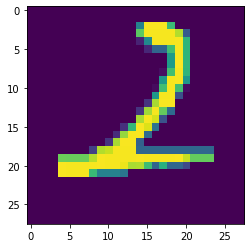

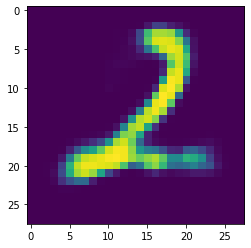

epoch 17 test bce loss 5850.5465 test kld 149.5563


100%|██████████| 469/469 [00:05<00:00, 89.18it/s]


epoch 18 train bce loss 34494.7529 train kld 887.3299


100%|██████████| 79/79 [00:00<00:00, 107.06it/s]


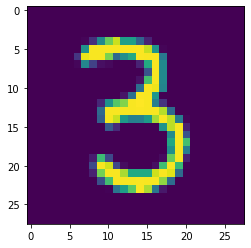

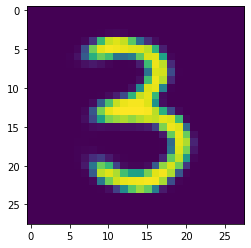

epoch 18 test bce loss 5804.1044 test kld 148.8838


100%|██████████| 469/469 [00:05<00:00, 89.82it/s]


epoch 19 train bce loss 34294.9324 train kld 885.5447


100%|██████████| 79/79 [00:00<00:00, 106.82it/s]


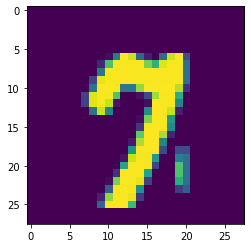

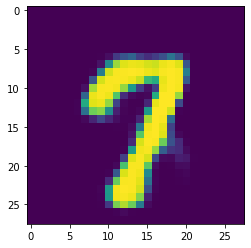

epoch 19 test bce loss 5782.6508 test kld 149.4409


100%|██████████| 469/469 [00:05<00:00, 89.87it/s]


epoch 20 train bce loss 34086.7551 train kld 884.4178


100%|██████████| 79/79 [00:00<00:00, 106.59it/s]


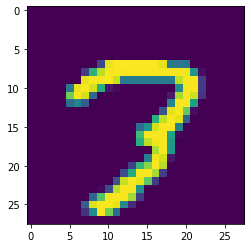

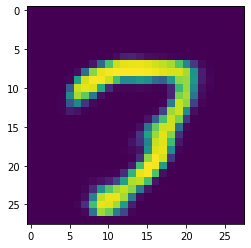

epoch 20 test bce loss 5745.2840 test kld 148.6499


100%|██████████| 469/469 [00:05<00:00, 89.96it/s]


epoch 21 train bce loss 33927.8970 train kld 884.1062


100%|██████████| 79/79 [00:00<00:00, 106.86it/s]


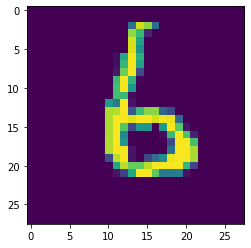

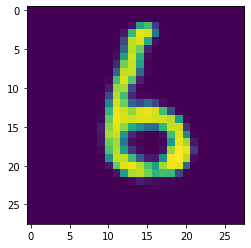

epoch 21 test bce loss 5703.9018 test kld 149.0407


100%|██████████| 469/469 [00:05<00:00, 89.62it/s]


epoch 22 train bce loss 33751.6464 train kld 882.7292


100%|██████████| 79/79 [00:00<00:00, 106.82it/s]


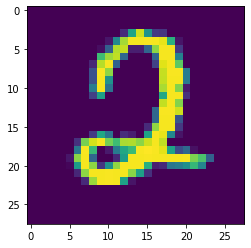

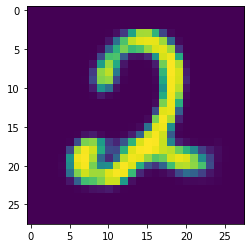

epoch 22 test bce loss 5689.4991 test kld 148.8770


100%|██████████| 469/469 [00:05<00:00, 88.66it/s]


epoch 23 train bce loss 33595.7930 train kld 882.1263


100%|██████████| 79/79 [00:00<00:00, 106.70it/s]


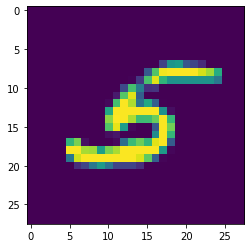

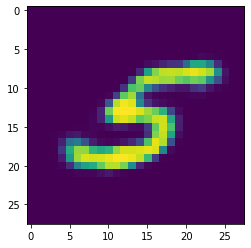

epoch 23 test bce loss 5668.5202 test kld 148.4133


100%|██████████| 469/469 [00:05<00:00, 90.12it/s]


epoch 24 train bce loss 33460.9288 train kld 881.3100


100%|██████████| 79/79 [00:00<00:00, 107.30it/s]


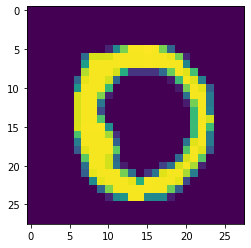

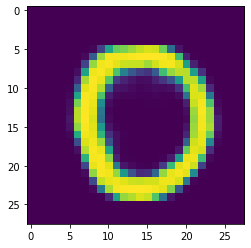

epoch 24 test bce loss 5669.4148 test kld 148.4156


100%|██████████| 469/469 [00:05<00:00, 87.38it/s]


epoch 25 train bce loss 33320.1644 train kld 879.6466


100%|██████████| 79/79 [00:00<00:00, 101.45it/s]


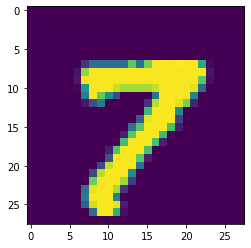

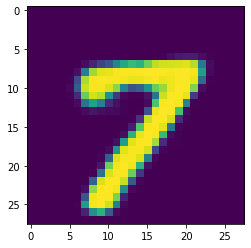

epoch 25 test bce loss 5633.1838 test kld 147.7815


100%|██████████| 469/469 [00:05<00:00, 88.73it/s]


epoch 26 train bce loss 33188.9168 train kld 877.8582


100%|██████████| 79/79 [00:00<00:00, 104.35it/s]


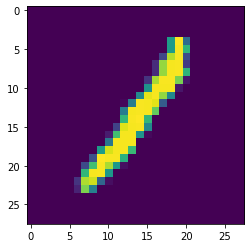

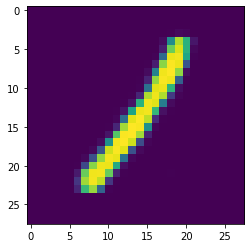

epoch 26 test bce loss 5618.7792 test kld 147.8396


 50%|████▉     | 233/469 [00:02<00:02, 84.47it/s]


RuntimeError: ignored

In [26]:
from tqdm import tqdm
for epoch in range(1,1000+1):
    train_bce_loss = 0.
    train_kld = 0.
    for data in tqdm(train_loader):
        optimizer.zero_grad()
        model.train()
        data,label = data[0].cuda(),data[1]
        output = model(data)
        bce,kld = loss_fct(output, data, args.input_dim, args.categorical_dim)
        loss = bce+kld
        loss.backward()
        train_bce_loss+=bce.item()
        train_kld+=kld.item()
        optimizer.step()
    print(f'epoch {epoch} train bce loss {train_bce_loss:.4f} train kld {train_kld:.4f}')
    val_bce_loss, val_kld=eval(model, test_loader)
    print(f'epoch {epoch} test bce loss {val_bce_loss:.4f} test kld {val_kld:.4f}')
    
    #plt.imshow(data[0,0,:,:])
    #plt.show()
    #plt.imshow(output[0].detach().numpy().reshape(-1,args.input_dim, args.input_dim)[0])
    #plt.show()